In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch import Tensor

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [2]:
SEED = 2023

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.cuda.is_available()

True

### Load Pre-Organized Dataset
- 由于已经将训练数据组织成tensor的形式了 因此直接通过`torch`导入

In [3]:
from data.dataloader import FusenetDataset
train_data = FusenetDataset(rgbd_path='dataset/train/rgbd-tiny.pt', mask_path='dataset/train/mask-tiny.pt')

rgbd_train = train_data.get_rgbd_set()
mask_train = train_data.get_mask_set()

- 检查一下样本数量

In [4]:
print(rgbd_train.shape)
print(mask_train.shape)

torch.Size([300, 4, 224, 224])
torch.Size([300, 224, 224])


- 随便看一些图

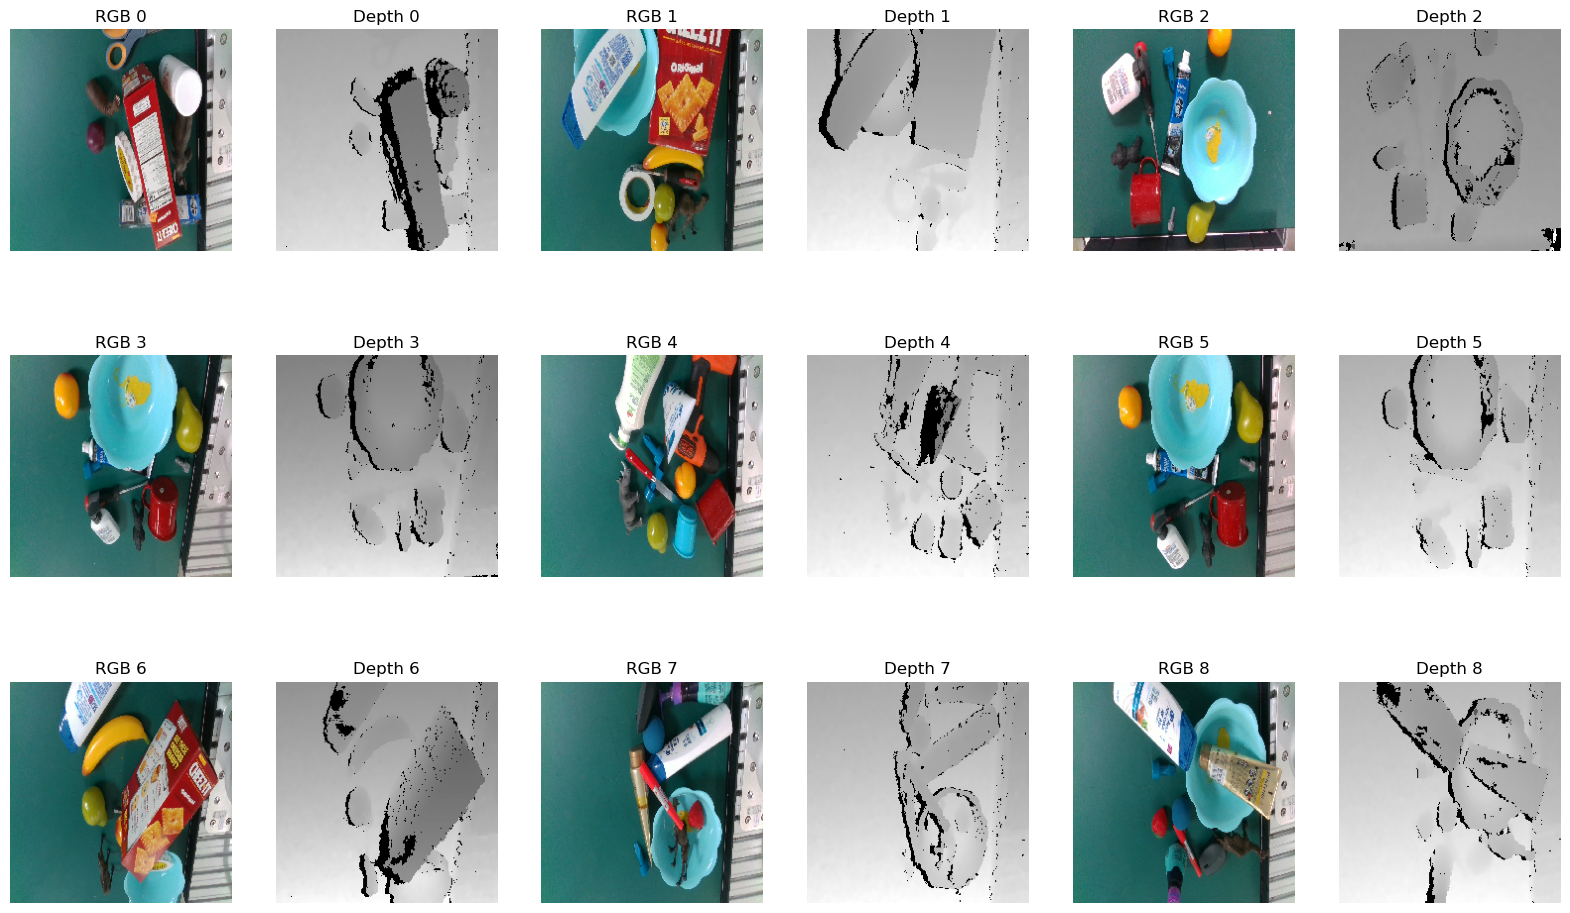

In [5]:
from visualization.plot import show_random_rgbd_imgs

show_random_rgbd_imgs(rgbd_train, num_rows=3, num_cols=3)

### Pre-Process the dataset
- 按通道计算一下图像的均值与方差 方便后续标准化操作

In [6]:
rgbd_means = rgbd_train.mean(dim=(0, 2, 3))
rgbd_stds = rgbd_train.std(dim=(0, 2, 3))
print(rgbd_means)
print(rgbd_stds)

tensor([3.1971e-01, 4.4479e-01, 4.2900e-01, 4.4204e+02])
tensor([  0.2699,   0.2102,   0.2219, 119.2154])


- 定义 `transforms.Compose` 完成标准化以及数据增强操作
- 由于不同的scene以及同一个scene的不同img都是在不同相机角度下采集的，因此不需要做随机旋转or随机翻转，本身就有较好的增强能力

In [7]:
rgbd_train_transforms = transforms.Normalize(mean=rgbd_means, std=rgbd_stds)
rgbd_train = rgbd_train_transforms(rgbd_train)

- 看一下标准化后的一些图

In [8]:
# TODO show imgs after normalization

### Load Pre-Defined model

- 为了清晰展示动态流程 静态网络框架已经在`./models/network.py`中实现

In [9]:
from models.network import Fusenet

OUTPUT_DIM = 88 + 1 # According to explanation of GraspNet, 1 means ground
model = Fusenet(num_labels= OUTPUT_DIM)

/home/yiju/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yiju/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


- 看一下需要学习的参数

In [10]:
from models.utils import count_parameters

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 44,260,505 trainable parameters


- 由于 `Fusenet` 的 `Encoder` 部分的 `Conv Layer` 都是基于 `VGG16` 在 `ImageNet` 数据预训练的结果权重 因此初始化只需要针对其他部分执行
- 由于 `model.apply` 方法会递归所有的layer 因此此处手动迭代模型

In [11]:
from models.network import init_params

init_params(model.need_initialization)

- 定义损失准则 将模型及准则上传到设备

In [12]:
from models.network import FusenetLoss
START_LR = 1e-3

criterion = FusenetLoss() 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)
criterion = criterion.to(device)

cuda


### Train on tiny set
- 由于不确定FuseNet在这个数据集上的效果，因此，参照课堂上以及CS231n所述，需要先 `Overfit a tiny subset of data`

In [13]:
n_tiny_set = 30
n_total = len(train_data)

tiny_set, _ = random_split(train_data, [n_tiny_set, n_total - n_tiny_set], torch.Generator().manual_seed(2023))
tiny_iter = DataLoader(tiny_set, batch_size=10, shuffle=True)
print(len(tiny_iter))


3


In [14]:
EPOCHS = 1

best_loss = float('inf')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 定义优化器

tiny_file_path = 'tiny-output.txt'
tiny_file_title = "\n".join([f"{key}: {value}" for key, value in optimizer.defaults.items()])

- 开始小样本过拟合测试

In [15]:
from models.train_eval import train, epoch_time

with open(tiny_file_path, 'a') as file:
        file.write('----------\n' + tiny_file_title + '\n')
        
for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    loss, glob_acc, mean_acc, iou_acc = train(model, tiny_iter, optimizer, criterion, device, tiny_set=True)
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # 将输出格式化为字符串
    output_string = (
        f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
        f'\tLoss: {loss:.3f} | Glob Acc: {glob_acc*100:.2f}% | Mean Acc: {mean_acc*100:.2f}% | Iou Acc: {iou_acc*100:.2f}%'
    )

    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), 'tiny-overfit-model.pt')

    # 打开文件并追加字符串
    with open(tiny_file_path, 'a') as file:
        file.write(output_string + '\n')

# 获取最大显存使用量
max_memory_allocated = torch.cuda.max_memory_allocated()

print(f"最大显存使用量: {max_memory_allocated / 2**20} mb")
    
    

/home/yiju/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1699449183005/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


最大显存使用量: 5830.06640625 mb


In [16]:
print(best_loss)

4.458949565887451


- 通过查看我们发现三个acc都已经超过90%了，说明该网络有完成任务的能力
- 接下来，我们通过可视化方法验证tinyset的过拟合结果

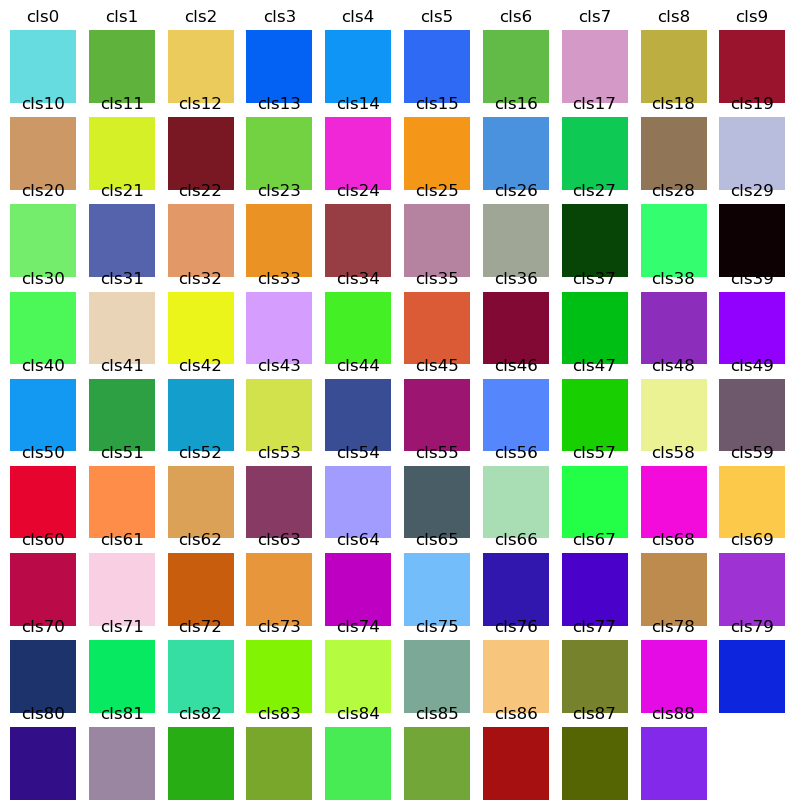

In [17]:
import matplotlib.pyplot as plt
from visualization.label2color import label2color_mapping, check_label2color_mapping

label_info = label2color_mapping(OUTPUT_DIM)

check_label2color_mapping(label_info)

- 一个用于获得prediction的函数

In [18]:
from models.train_eval import get_predictions

rgbs, masks, preds = get_predictions(model, tiny_iter, device)
rgbs = rgbs.to('cpu')
masks = masks.to('cpu')
preds = preds.to('cpu')
print(rgbs.shape)
print(masks.shape)
print(preds.shape)

torch.Size([30, 3, 224, 224])
torch.Size([30, 224, 224])
torch.Size([30, 224, 224])


- 一个用于可视化原图、标签以及预测结果的函数

In [19]:
from visualization.plot import visualize_predictions

# 调用可视化函数
# visualize_predictions(rgbs, masks, preds, label_info)


### Train on full set
- 接下来，调用全数据集进行训练，首先导入所有数据并进行标准化

In [20]:
from data.dataloader import FusenetDataset
train_data = FusenetDataset(rgbd_path='dataset/train/rgbd-full.pt', mask_path='dataset/train/mask-full.pt')
test_data = FusenetDataset(rgbd_path='dataset/test/rgbd-test.pt', mask_path='dataset/test/mask-test.pt')

rgbd_train = train_data.get_rgbd_set()
mask_train = train_data.get_mask_set()

rgbd_test = test_data.get_rgbd_set()
mask_test = test_data.get_mask_set()

print(rgbd_train.shape)
print(mask_train.shape)
print(rgbd_test.shape)
print(mask_test.shape)

rgbd_means = rgbd_train.mean(dim=(0, 2, 3))
rgbd_stds = rgbd_train.std(dim=(0, 2, 3))

print(rgbd_means)
print(rgbd_stds)

rgbd_train_transforms = transforms.Normalize(mean=rgbd_means, std=rgbd_stds)
rgbd_test_transforms = transforms.Normalize(mean=rgbd_means, std=rgbd_stds) # using same norm params 

rgbd_train = rgbd_train_transforms(rgbd_train)
rgbd_test = rgbd_test_transforms(rgbd_test)

torch.Size([2500, 4, 224, 224])
torch.Size([2500, 224, 224])
torch.Size([300, 4, 224, 224])
torch.Size([300, 224, 224])
tensor([3.0658e-01, 4.3537e-01, 4.1647e-01, 4.2806e+02])
tensor([  0.2771,   0.2077,   0.2201, 129.0721])


- 随后将数据集组织为训练集、验证集以及测试集

In [21]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_set, valid_set = random_split(train_data, [n_train_examples, n_valid_examples])
test_set = test_data
print(len(train_set))
print(len(valid_set))
print(len(test_set))

train_iter = DataLoader(train_set, batch_size=10, shuffle=True)
valid_iter = DataLoader(valid_set, batch_size=10, shuffle=False)
test_iter = DataLoader(test_set, batch_size=10, shuffle=False)

print(len(train_iter))
print(len(valid_iter))
print(len(test_iter))

2250
250
300
225
25
30


- 接着重置参数，避免过拟合参数影响泛化训练

In [22]:
print(f"当前显存使用量: {torch.cuda.memory_allocated() / 2**20} mb")
model.to('cpu')
print(f"当前显存使用量: {torch.cuda.memory_allocated() / 2**20} mb")
model = Fusenet(num_labels= OUTPUT_DIM)
init_params(model.need_initialization)

当前显存使用量: 514.43115234375 mb
当前显存使用量: 342.8466796875 mb


/home/yiju/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yiju/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


- 开始训练

In [23]:
best_valid_loss = float('inf')

In [24]:
from models.network import FusenetLoss

START_LR = 0.001
EPOCHS = 25
l2_alpha = 5e-4
criterion = FusenetLoss(alpha=0) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)
criterion = criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=START_LR, weight_decay=l2_alpha) # 定义优化器

file_path = 'full-output.txt'
file_title = "\n".join([f"{key}: {value}" for key, value in optimizer.defaults.items()])

cuda


In [38]:
print(f"当前显存使用量: {torch.cuda.memory_allocated() / 2**20} mb")

当前显存使用量: 171.47509765625 mb


In [26]:
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()

In [27]:
# model.load_state_dict(torch.load('fuse-model.pt'))

In [26]:
from models.train_eval import train, evaluate

with open(file_path, 'a') as file:
        file.write('----------\n' + file_title + '\n')
        
for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    optimizer.zero_grad()
    train_loss, train_glob, train_mean, train_iou = train(model, train_iter, optimizer, criterion, device, False)
    valid_loss, valid_glob, valid_mean, valid_iou = evaluate(model, valid_iter, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'fuse-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # 将输出格式化为字符串
    output_string = (
        f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
        f'\t[Train] Loss: {train_loss:.3f} | Glob Acc: {train_glob*100:.2f}% | Mean Acc: {train_mean*100:.2f}% | Iou Acc: {train_iou*100:.2f}%\n'
        f'\t[valid] Loss: {valid_loss:.3f} | Glob Acc: {valid_glob*100:.2f}% | Mean Acc: {valid_mean*100:.2f}% | Iou Acc: {valid_iou*100:.2f}%\n'
    )
    if epoch % 10 == 0:
        test_loss, test_glob, test_mean, test_iou = evaluate(model, test_iter, criterion, device)
        output_string += f'\t[Test] Loss: {test_loss:.3f} | Glob Acc: {test_glob*100:.2f}% | Mean Acc: {test_mean*100:.2f}% | Iou Acc: {test_iou*100:.2f}%\n'

    # 打开文件并追加字符串
    with open(file_path, 'a') as file:
        file.write(output_string + '\n')
    
    

In [31]:
print(best_valid_loss)

0.2374213969707489


In [25]:
model.load_state_dict(torch.load('fuse-model.pt'))

<All keys matched successfully>

In [53]:
from models.train_eval import get_predictions

rgbs, masks, preds = get_predictions(model, test_iter, device)
rgbs = rgbs.to('cpu')
masks = masks.to('cpu')
preds = preds.to('cpu')
print(rgbs.shape)
print(masks.shape)
print(preds.shape)

torch.Size([300, 3, 224, 224])
torch.Size([300, 224, 224])
torch.Size([300, 224, 224])


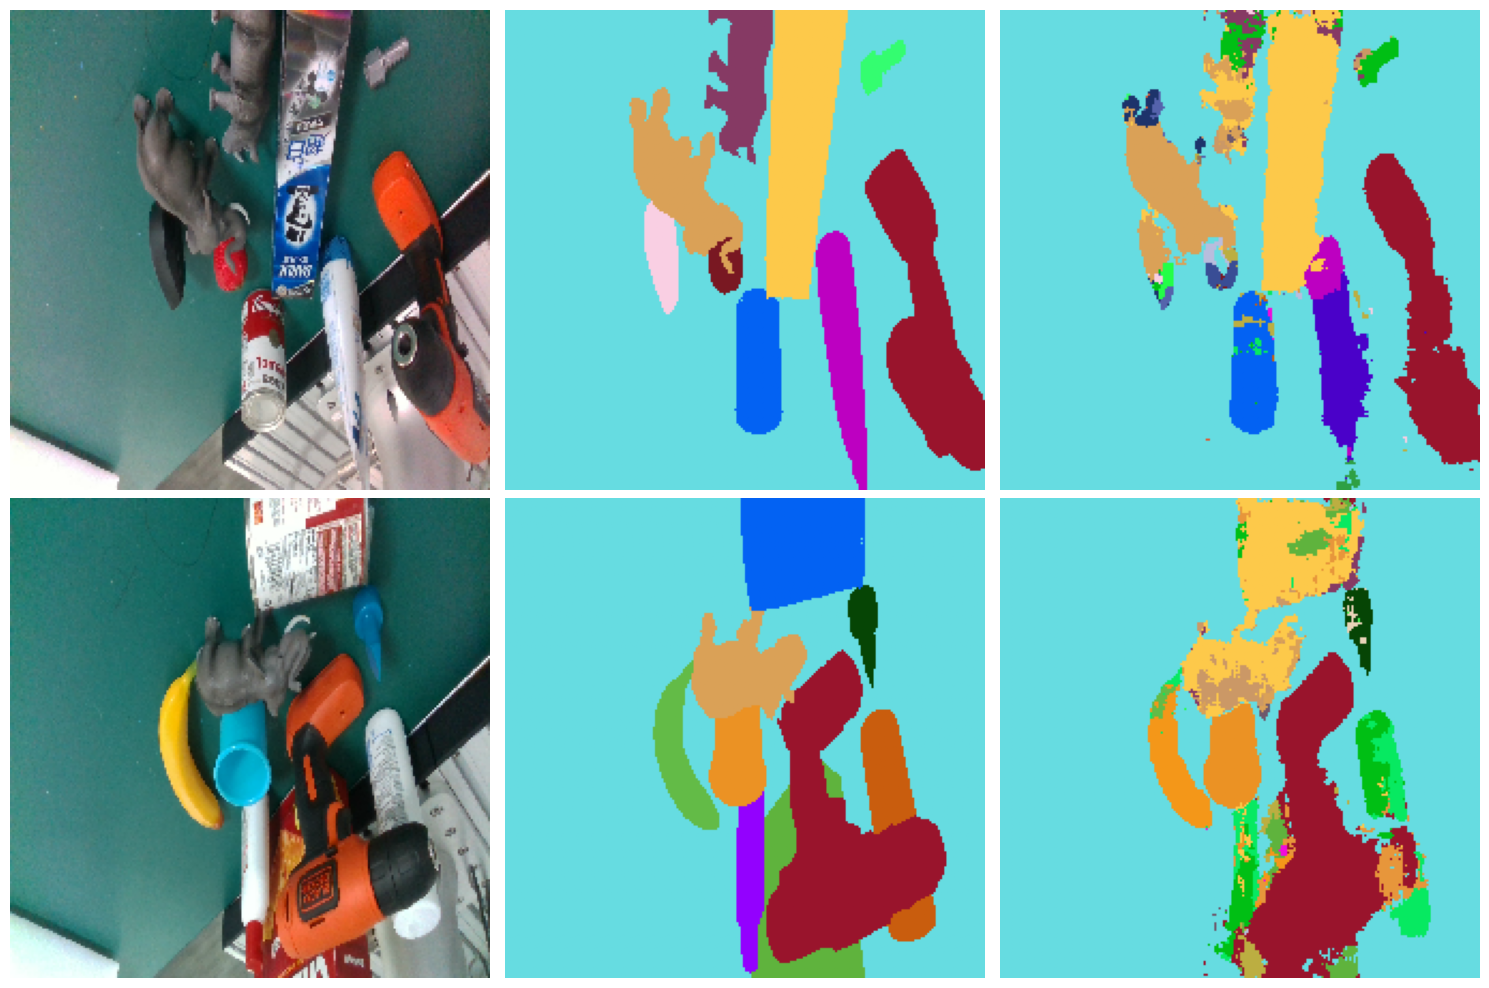

In [77]:
from visualization.plot import visualize_predictions

# 调用可视化函数
visualize_predictions(rgbs, masks, preds, label_info, num_rows=2, num_cols=3)

In [ ]:
def visualize_predictions(rgb, mask, pred, label_info: dict, num_rows=30, num_cols=3):
    assert len(rgb) == len(mask) == len(pred), "Input lists must have the same length"

    # 设置图像大小
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

    random_indices = np.random.choice(len(rgb), num_rows, replace=False)

    for i, idx in enumerate(random_indices):
        # 提取当前样本的 RGB、Mask 和 Pred
        cur_rgb: Tensor = rgb[idx]
        cur_mask: Tensor = torch.zeros_like(cur_rgb)
        cur_pred: Tensor = torch.zeros_like(cur_rgb)

        cur_rgb = cur_rgb.permute(1,2,0)
        cur_mask = cur_mask.permute(1,2,0)
        cur_pred = cur_pred.permute(1,2,0)

        for label, info in label_info.items():
            
            cur_mask[mask[idx] == label] = torch.tensor(info['color'])
            cur_pred[pred[idx] == label] = torch.tensor(info['color'])

        # 在subplot中显示图像
        axes[i, 0].imshow(cur_rgb)
        axes[i, 0].axis('off')
        axes[i, 1].imshow(cur_mask)
        axes[i, 1].axis('off')
        axes[i, 2].imshow(cur_pred)
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

